## Choosing the right ML algorithms

To be able to choose the right machine learning models, we need to formulate a clear and concise description of our problem. We would like to predict cancer malignancy (diagnosis) by looking at the size of cell features from images of cell substracts. The features of the cells concern the mean texture, mean radius, area, concavity and other geometrical features of the cells themself. With that said, the task of predicting whether a cancer diagnosis is malignant or benign, is clearly a classification task. 

Since in our dataset we already have the labeled diagnosis, it seems prudent to test some of the supervised models which scikit-learn offers. But first we need to import and prepare the data. 

In [16]:
# Load data
import pandas as pd
import matplotlib.pyplot as plt

# Read dataset
data_breast_cancer = pd.read_csv("breast_cancer_win/data.csv")

# data (as pandas dataframes)
print(data_breast_cancer.shape)
features = data_breast_cancer.columns
print(len(features))

print("Data features: \n", features)
print(data_breast_cancer.describe())

(569, 33)
33
Data features: 
 Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')
                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351

Here we have printed all the features the data contains, and the description of the data. After we drop the columns that is not relevant to the model.

In [17]:
# Prepare the dataset
means_labels : list[str] = list(data_breast_cancer.columns[1:11])
worst_labels : list[str] = list(data_breast_cancer.columns[-10: -1])

# Drop the irrelevant features
data_breast_cancer.drop(columns=["Unnamed: 32", "id"], inplace=True)

print(data_breast_cancer.iloc[0])

diagnosis                         M
radius_mean                   17.99
texture_mean                  10.38
perimeter_mean                122.8
area_mean                    1001.0
smoothness_mean              0.1184
compactness_mean             0.2776
concavity_mean               0.3001
concave points_mean          0.1471
symmetry_mean                0.2419
fractal_dimension_mean      0.07871
radius_se                     1.095
texture_se                   0.9053
perimeter_se                  8.589
area_se                       153.4
smoothness_se              0.006399
compactness_se              0.04904
concavity_se                0.05373
concave points_se           0.01587
symmetry_se                 0.03003
fractal_dimension_se       0.006193
radius_worst                  25.38
texture_worst                 17.33
perimeter_worst               184.6
area_worst                   2019.0
smoothness_worst             0.1622
compactness_worst            0.6656
concavity_worst             

Since we are having a binary classification, is it important to change the diagnosis string to binary integer 0 and 1. 1 is Malignant and 0 is Binail. 

In [18]:

# Set the data diagnosis results to integers
data_breast_cancer['diagnosis'] = data_breast_cancer['diagnosis'].map({"M":1,"B":0})
# split dataframe into two based on diagnosis
dfM=data_breast_cancer[data_breast_cancer['diagnosis'] == 1]
dfB=data_breast_cancer[data_breast_cancer['diagnosis'] == 0]

# Copy result array and drop it from our dataset
y_all = data_breast_cancer["diagnosis"].copy()
data_breast_cancer.drop(columns=["diagnosis"], inplace=True)

In dataanalyse_ans notebook we printed a lot of histograms. We added a skewness number to the top right corner.

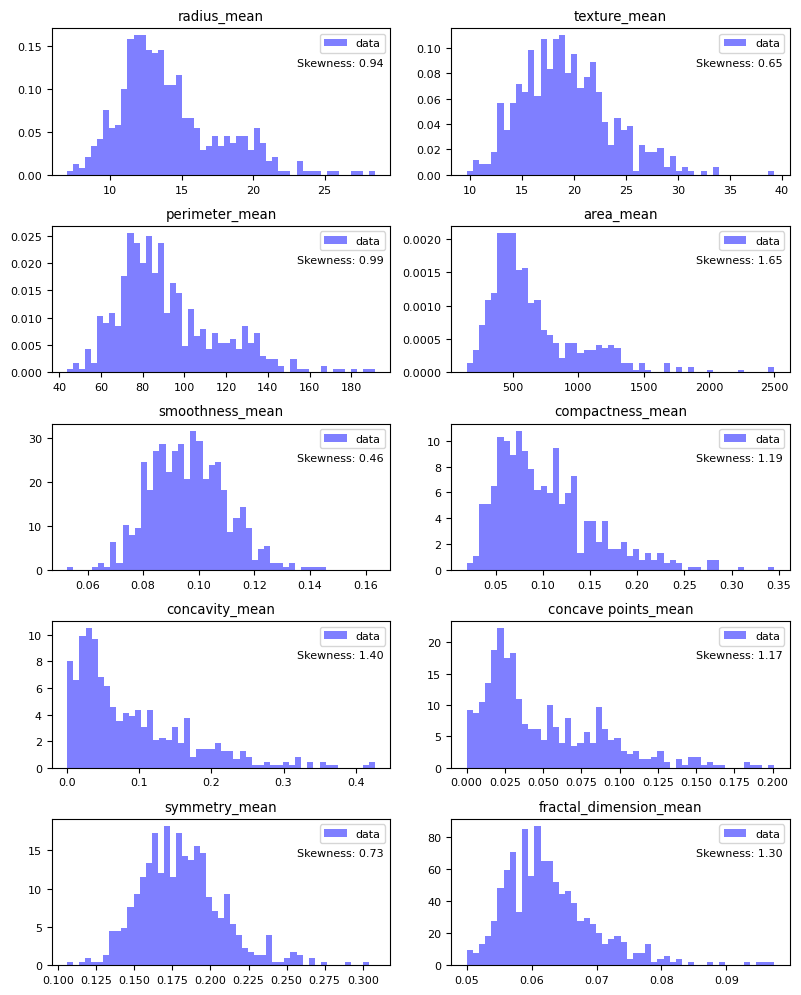

As showns in the skewness number, and the histograms themselves, some of the data is skewed a lot and can be changed by taking the logaritme of the features. The features to change is those with worst skewness. This will make the model better at generalizing.

In [19]:
from sklearn.preprocessing import StandardScaler
import numpy as np
skewed_features = ['perimeter_mean','area_mean','compactness_mean','concavity_mean', 'concave points_mean', 'fractal_dimension_mean']

# Apply logarithm transformation to skewed features and standard scale the result
def transform_log(data) -> np.ndarray:
    for feature in skewed_features:
        data[feature] = np.log1p(data[feature])

    # Check skewness after transformation
    skewness_after_transformation = data[skewed_features].skew()
    print("Skewness after logarithm transformation:")
    print(skewness_after_transformation)

    # StandardScale the dataset
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data)
    print(standardized_data)
    return standardized_data

We use StandarScaler to transform the entire dataset, so the bigger data numbers don't outshine the smaller ones. This way all data has almost equal influence in the training of the model. We are using StandardScaler above MinMaxScaler as it is more robust to outliers. After we setup some helper methods for grid search + printing results

In [20]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import learning_curve
import numpy as np

def SearchReport(model):
    def GetBestModelCTOR(model, best_params):
        def GetParams(best_params):
            ret_str=""
            for key in sorted(best_params):
                value = best_params[key]
                temp_str = "'" if str(type(value))=="<class 'str'>" else ""
                if len(ret_str)>0:
                    ret_str += ','
                ret_str += f'{key}={temp_str}{value}{temp_str}'
            return ret_str
        try:
            param_str = GetParams(best_params)
            return type(model).__name__ + '(' + param_str + ')'
        except:
            return "N/A(1)"

    print("\nBest model set found on train set:")
    print()
    print(f"\tbest parameters={model.best_params_}")
    print(f"\tbest '{model.scoring}' score={model.best_score_}")
    print(f"\tbest index={model.best_index_}")
    print()
    print(f"Best estimator CTOR:")
    print(f"\t{model.best_estimator_}")
    print()
    try:
        print(f"Grid scores ('{model.scoring}') on development set:")
        means = model.cv_results_['mean_test_score']
        stds  = model.cv_results_['std_test_score']
        i=0
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("\t[%2d]: %0.3f (+/-%0.03f) for %r" % (i, mean, std * 2, params))
            i += 1
    except:
        print("WARNING: the random search do not provide means/stds")

    global currmode
    assert "f1_micro"==str(model.scoring), f"come on, we need to fix the scoring to be able to compare model-fits! Your scoreing={str(model.scoring)}...remember to add scoring='f1_micro' to the search"
    return f"best: score={model.best_score_:0.5f}, model={GetBestModelCTOR(model.estimator,model.best_params_)}", model.best_estimator_


def ClassificationReport(model, X_test, y_test, target_names=None):
    assert X_test.shape[0]==y_test.shape[0]
    print("\nDetailed classification report:")
    print("\tThe model is trained on the full development set.")
    print("\tThe scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred, target_names=target_names))
    print()

def FullReport(model, X_test, y_test, t):
    print(f"SEARCH TIME: {t:0.2f} sec")
    beststr, bestmodel = SearchReport(model)
    ClassificationReport(model, X_test, y_test)
    print(f"CTOR for best model: {bestmodel}\n")
    print(f"{beststr}\n")
    return beststr, bestmodel

# Just a container for the data
class Data:
    def __init__(self, x_train, y_train, x_test, y_test) -> None:
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

def doGridSearch(data: Data, model, tuning_parameters: dict):

    def trainAndReport(gridcv, data: Data):
        start = time()
        gridcv.fit(data.x_train, data.y_train)
        t = time() - start

        b0, m0 = FullReport(gridcv, data.x_test, data.y_test, t)
        print('OK(grid-search)')
        return b0, m0

    grid_tuned = GridSearchCV(model,
                          tuning_parameters,
                          cv=CV_layers,
                          scoring='f1_micro',
                          verbose=VERBOSE,
                          n_jobs=-1)

    scores = trainAndReport(grid_tuned, data)
    return scores

def justScore(s):
    s_no = s[s.find("0"): s.find("0") + 7]
    return float(s_no)

def getBestScore(data, modelCtor, tuningParameters, description):
    b, m = doGridSearch(data, modelCtor(), tuningParameters)
    b_score = justScore(b)
    return("best score for " + description + ": " + str(b_score), b_score)

CV_layers = 5
VERBOSE = 2

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Accuracy score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

After writing the helper methods, we use the transform_log to transform the dataset to perform better. After this we split the data.

In [21]:
# Preprocess the data
data_pre = transform_log(data_breast_cancer)
X_train, X_test, Y_train, Y_test = train_test_split(data_pre, y_all, test_size = 0.25, shuffle=True)
data = Data(X_train, Y_train, X_test, Y_test)

Skewness after logarithm transformation:
perimeter_mean            0.328800
area_mean                 0.287328
compactness_mean          1.043195
concavity_mean            1.206982
concave points_mean       1.083180
fractal_dimension_mean    1.272294
dtype: float64
[[ 1.09706398 -2.07333501  1.28162791 ...  2.29607613  2.75062224
   1.93701461]
 [ 1.82982061 -0.35363241  1.59772138 ...  1.0870843  -0.24388967
   0.28118999]
 [ 1.57988811  0.45618695  1.50947042 ...  1.95500035  1.152255
   0.20139121]
 ...
 [ 0.70228425  2.0455738   0.77954796 ...  0.41406869 -1.10454895
  -0.31840916]
 [ 1.83834103  2.33645719  1.80881986 ...  2.28998549  1.91908301
   2.21963528]
 [-1.80840125  1.22179204 -2.46059019 ... -1.74506282 -0.04813821
  -0.75120669]]


The first model to test is a SGDClassifier, but first we will find the best parameters using GridSearchCV just as we did in O3

In [12]:
# Use some classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from time import time

scores = {}

model = SGDClassifier()

tuning_parameters = {
    'loss': ['hinge', 'log_loss', 'perceptron', 'modified_huber', 'squared_error', 'huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha' : [0.0001, 0.001, 0.01, 0.1],
    'tol' : [0.0001, 0.001, 0.01, 0.1],
    'max_iter' : [int(1e+6)]
}

scores = doGridSearch(data, model, tuning_parameters)
print(scores)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


We save our SGDClassifier and do the same, as above for a RidgeClassifier.

In [23]:
from sklearn.linear_model import SGDClassifier

VERBOSE = 0

# Chosen model
sgd = SGDClassifier(alpha=0.01, loss='log_loss', max_iter=1000000, tol=0.0001)

model = RidgeClassifier()
tuning_parameters = {
        'alpha' : [0.01, 0.1, 1, 2, 10],
        'tol' : [0.00001, 0.0001, 0.001],
        'solver' : ['svd', 'cholesky', 'lsqr', 'sag']
    }

scores = doGridSearch(data, model, tuning_parameters)

print(scores)


SEARCH TIME: 2.34 sec

Best model set found on train set:

	best parameters={'alpha': 0.01, 'solver': 'svd', 'tol': 1e-05}
	best 'f1_micro' score=0.95781121751026
	best index=0

Best estimator CTOR:
	RidgeClassifier(alpha=0.01, solver='svd', tol=1e-05)

Grid scores ('f1_micro') on development set:
	[ 0]: 0.958 (+/-0.031) for {'alpha': 0.01, 'solver': 'svd', 'tol': 1e-05}
	[ 1]: 0.958 (+/-0.031) for {'alpha': 0.01, 'solver': 'svd', 'tol': 0.0001}
	[ 2]: 0.958 (+/-0.031) for {'alpha': 0.01, 'solver': 'svd', 'tol': 0.001}
	[ 3]: 0.958 (+/-0.031) for {'alpha': 0.01, 'solver': 'cholesky', 'tol': 1e-05}
	[ 4]: 0.958 (+/-0.031) for {'alpha': 0.01, 'solver': 'cholesky', 'tol': 0.0001}
	[ 5]: 0.958 (+/-0.031) for {'alpha': 0.01, 'solver': 'cholesky', 'tol': 0.001}
	[ 6]: 0.958 (+/-0.031) for {'alpha': 0.01, 'solver': 'lsqr', 'tol': 1e-05}
	[ 7]: 0.958 (+/-0.031) for {'alpha': 0.01, 'solver': 'lsqr', 'tol': 0.0001}
	[ 8]: 0.953 (+/-0.033) for {'alpha': 0.01, 'solver': 'lsqr', 'tol': 0.001}
	[ 9]

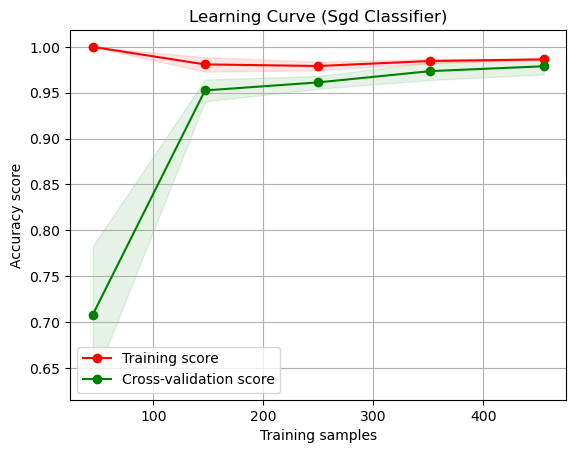

In [28]:
CV = 5
X = data_pre
y = y_all

title = "Learning Curve (Sgd Classifier)"
plot_learning_curve(sgd, title, X, y, cv=CV)
plt.show()

We also save the RidgeClassifier model and gridsearch a GaussianProcessClassifier. Lastly we print a learning curve.

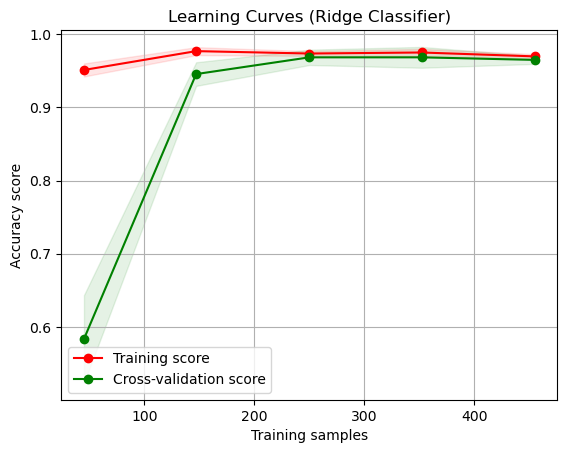

In [24]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier(alpha=10, solver='svd', tol=1e-05)

title = "Learning Curve (Ridge Classifier)"
plot_learning_curve(ridge, title, X, y, cv=CV)
plt.show()

In [25]:


model = GaussianProcessClassifier()

tuning_parameters = {
    'n_restarts_optimizer' : [0, 2, 5],
    'max_iter_predict' : [100, 500, 1000]
}

scores = doGridSearch(data, model, tuning_parameters)
print(scores)


SEARCH TIME: 0.51 sec

Best model set found on train set:

	best parameters={'max_iter_predict': 100, 'n_restarts_optimizer': 0}
	best 'f1_micro' score=0.9695212038303694
	best index=0

Best estimator CTOR:
	GaussianProcessClassifier()

Grid scores ('f1_micro') on development set:
	[ 0]: 0.970 (+/-0.051) for {'max_iter_predict': 100, 'n_restarts_optimizer': 0}
	[ 1]: 0.970 (+/-0.051) for {'max_iter_predict': 100, 'n_restarts_optimizer': 2}
	[ 2]: 0.970 (+/-0.051) for {'max_iter_predict': 100, 'n_restarts_optimizer': 5}
	[ 3]: 0.970 (+/-0.051) for {'max_iter_predict': 500, 'n_restarts_optimizer': 0}
	[ 4]: 0.970 (+/-0.051) for {'max_iter_predict': 500, 'n_restarts_optimizer': 2}
	[ 5]: 0.970 (+/-0.051) for {'max_iter_predict': 500, 'n_restarts_optimizer': 5}
	[ 6]: 0.970 (+/-0.051) for {'max_iter_predict': 1000, 'n_restarts_optimizer': 0}
	[ 7]: 0.970 (+/-0.051) for {'max_iter_predict': 1000, 'n_restarts_optimizer': 2}
	[ 8]: 0.970 (+/-0.051) for {'max_iter_predict': 1000, 'n_restarts_o

Next, we'll try a DecisionTreeClassifier

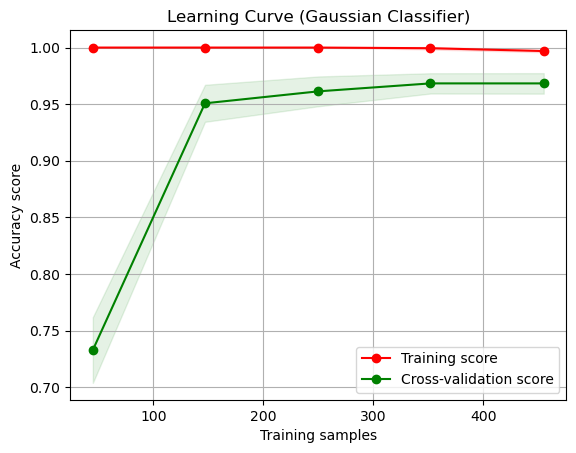

In [26]:
from sklearn.tree import DecisionTreeClassifier

gauss = GaussianProcessClassifier()

title = "Learning Curve (Gaussian Classifier)"
plot_learning_curve(gauss, title, X, y, cv=CV)
plt.show()

In [ ]:

model = DecisionTreeClassifier()

tuning_parameters = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [2, 5, None],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 5, 10]
}

scores = doGridSearch(data, model, tuning_parameters)
print(scores)

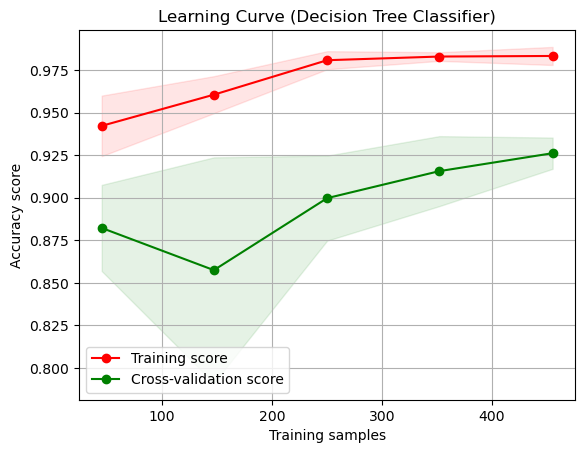

In [27]:
dtree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=2,
                       min_samples_split=10)

title = "Learning Curve (Decision Tree Classifier)"
plot_learning_curve(dtree, title, X, y, cv=CV)
plt.show()

In [115]:
# Try dummy classifier for a more realistic comparison of score

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Classifies EVERYTHING in the most frequent class (here 1 == Malignant tumor diagnosis)

def CompareToDummy(data: Data, model):
    dummy_clf = DummyClassifier()
    dummy_clf.fit(data.x_train, data.y_train)
    dummy_y = dummy_clf.predict(data.x_test)

    model.fit(data.x_train, data.y_train)
    model_y = model.predict(data.x_test)

    a_s = accuracy_score(data.y_test, model_y)
    c_v_s = cross_val_score(model, data.x_train, data.y_train, cv=3, scoring="accuracy")
    a_s_dummy = accuracy_score(data.y_test, dummy_y)
    c_v_s_dummy = cross_val_score(dummy_clf, data.x_train, data.y_train, cv = 3, scoring="accuracy")
    print(type(model).__name__)
    print("Model accuracy: ", a_s, " | Dummy accuracy: ", a_s_dummy)
    print("Model cvs: ", "c_v_s", c_v_s, " | Dummy cvs: ", c_v_s_dummy, "\n")

    return (a_s, c_v_s)


Comparing cross val score and accuracy of model to dummy classifier scores

SGDClassifier
Model accuracy:  0.8011695906432749  | Dummy accuracy:  0.5555555555555556
Model cvs:  c_v_s [0.78947368 0.78195489 0.90909091]  | Dummy cvs:  [0.65413534 0.66165414 0.65909091] 

RidgeClassifier
Model accuracy:  0.935672514619883  | Dummy accuracy:  0.5555555555555556
Model cvs:  c_v_s [0.94736842 0.96992481 0.95454545]  | Dummy cvs:  [0.65413534 0.66165414 0.65909091] 

DecisionTreeClassifier
Model accuracy:  0.9122807017543859  | Dummy accuracy:  0.5555555555555556
Model cvs:  c_v_s [0.95488722 0.93233083 0.9469697 ]  | Dummy cvs:  [0.65413534 0.66165414 0.65909091] 

GaussianProcessClassifier
Model accuracy:  0.847953216374269  | Dummy accuracy:  0.5555555555555556
Model cvs:  c_v_s [0.81954887 0.84210526 0.86363636]  | Dummy cvs:  [0.65413534 0.66165414 0.65909091] 

SGDClassifier
Model accuracy:  0.9064327485380117  | Dummy accuracy:  0.6374269005847953
Model cvs:  c_v_s [0.87218045 0.766917

[Text(0, 0, '0.856725'),
 Text(0, 0, '0.95848'),
 Text(0, 0, '0.934503'),
 Text(0, 0, '0.875439')]

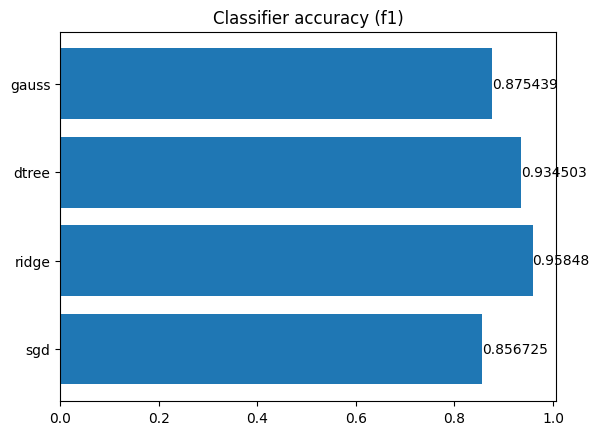

In [116]:
import numpy as np
accuracies = {}

iterations = 10

# Take an average accuracy score from 10 iterations, since they change between fits!

print("Comparing cross val score and accuracy of model to dummy classifier scores\n")
sgd_accuracies = []
ridge_accuracies = []
dtree_accuracies = []
gauss_accuracies = []
for i in range(iterations):
    x_train, x_test, y_train, y_test = train_test_split(data_breast_cancer, y_all, test_size=0.3, shuffle=True)
    data = Data(x_train, y_train, x_test, y_test)

    scores = CompareToDummy(data, sgd)
    sgd_accuracies.append(scores[0])

    scores = CompareToDummy(data, ridge)
    ridge_accuracies.append(scores[0])

    scores = CompareToDummy(data, dtree)
    dtree_accuracies.append(scores[0])

    scores = CompareToDummy(data, gauss)
    gauss_accuracies.append(scores[0])

accuracies["sgd"] = np.mean(sgd_accuracies)
accuracies["ridge"] = np.mean(ridge_accuracies)
accuracies["dtree"] = np.mean(dtree_accuracies)
accuracies["gauss"] = np.mean(gauss_accuracies)
print(accuracies)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bars = ax.barh(np.arange(len(accuracies)), list(accuracies.values()))
plt.title("Classifier accuracy (f1)")
plt.yticks(range(len(accuracies)), list(accuracies.keys()))
ax.bar_label(bars)


Let's draw the confusion matrices

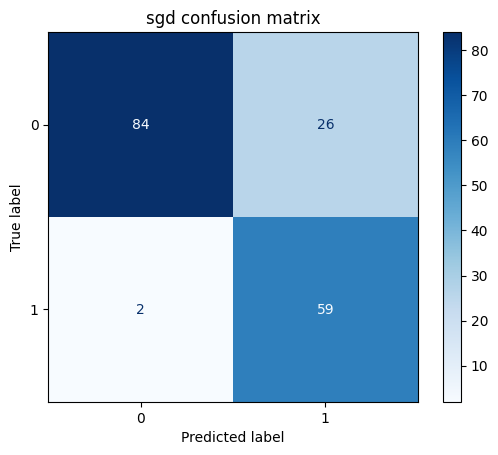

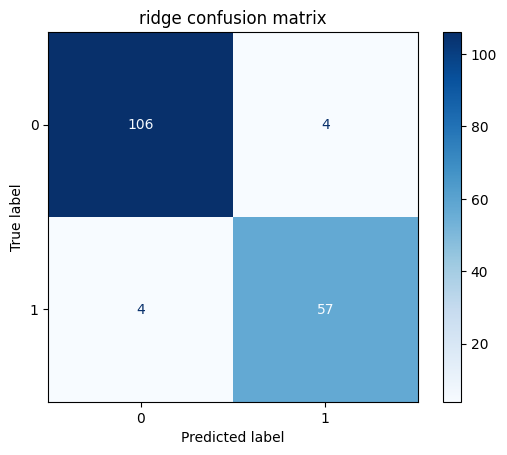

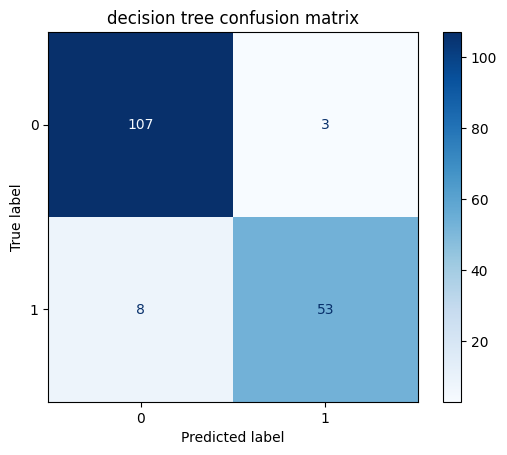

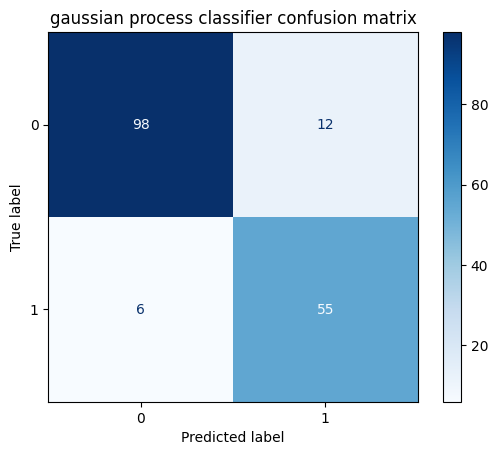

In [117]:
from sklearn.metrics import ConfusionMatrixDisplay

def saveConfMatrix(model, datax, datay, description):
    display = ConfusionMatrixDisplay.from_estimator(model, datax, datay, cmap=plt.cm.Blues)
    display.ax_.set_title(description)
    path = "images/results/" + description + ".png"
    plt.savefig(path)

display = ConfusionMatrixDisplay.from_estimator(sgd, data.x_test, data.y_test, cmap=plt.cm.Blues)
display.ax_.set_title("sgd confusion matrix")
plt.savefig("images/results/sgd_conf.png")
display_2 = ConfusionMatrixDisplay.from_estimator(ridge, data.x_test, data.y_test, cmap=plt.cm.Blues)
display_2.ax_.set_title("ridge confusion matrix")
plt.savefig("images/results/ridge_conf.png")
display_3 = ConfusionMatrixDisplay.from_estimator(dtree, data.x_test, data.y_test, cmap=plt.cm.Blues)
display_3.ax_.set_title("decision tree confusion matrix")
plt.savefig("images/results/dtree_conf.png")
display_4 = ConfusionMatrixDisplay.from_estimator(gauss,data.x_test, data.y_test, cmap=plt.cm.Blues)
display_4.ax_.set_title("gaussian process classifier confusion matrix")
plt.savefig("images/results/gauss_conf.png")


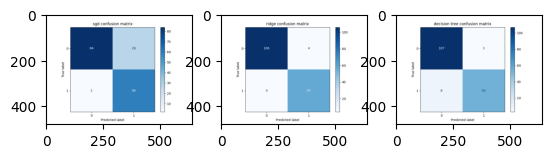

In [118]:
import matplotlib.image as img

plt.clf()
img_sgd = img.imread("images/results/sgd_conf.png")
img_ridge = img.imread("images/results/ridge_conf.png")
img_dtree = img.imread("images/results/dtree_conf.png")
img_gauss = img.imread("images/results/gauss_conf.png")
plt.subplot(1, 4, 1)
plt.imshow(img_sgd)
plt.subplot(1, 4, 2)
plt.imshow(img_ridge)
plt.subplot(1, 4, 3)
plt.imshow(img_dtree)
plt.subplot(1, 4, 4)
plt.imshow(img_gauss)
plt.savefig("images/results/all_conf.png")

Try to run the algorithm on means and worst separately to see if we can get a better result with different data. For example, can we get better results from only considering the means or the worst features from the dataset?

In [123]:
# Split the data into different feature sets: models can perform differently based on which data we feed them!

data_pre_df = pd.DataFrame(data_pre)
data_breast_means = data_pre_df[data_pre_df.columns[0: 10]].copy()
data_breast_worst = data_pre_df[data_pre_df.columns[-10: ]].copy()
data_breast_se = data_pre_df[data_pre_df.columns[10: -10]].copy()
data_breast_mw =  data_breast_means.copy().join(data_breast_worst)
print(data_breast_mw.describe())

X_train_means, X_test_means, Y_train_means, Y_test_means = train_test_split(data_breast_means, y_all, test_size = 0.25, shuffle=True)
X_train_worst, X_test_worst, Y_train_worst, Y_test_worst = train_test_split(data_breast_worst, y_all, test_size = 0.25, shuffle=True)
X_train_se, X_test_se, Y_train_se, Y_test_se = train_test_split(data_breast_se, y_all, test_size = 0.25, shuffle=True)
X_train_mw, X_test_mw, Y_train_mw, Y_test_mw = train_test_split(data_breast_mw, y_all, test_size = 0.25, shuffle=True)

data_means = Data(X_train_means, Y_train_means, X_test_means, Y_test_means)
data_worst = Data(X_train_worst, Y_train_worst, X_test_worst, Y_test_worst)
data_se = Data(X_train_se, Y_train_se, X_test_se, Y_test_se)
data_mw = Data(X_train_mw, Y_train_mw, X_test_mw, Y_test_mw)

def testAllData(modelCtor, tuning_parameters):
    results = []
    results.append(getBestScore(data, modelCtor, tuning_parameters, "normal data"))
    results.append(getBestScore(data_means, modelCtor, tuning_parameters, "means"))
    results.append(getBestScore(data_se, modelCtor, tuning_parameters, "se"))
    results.append(getBestScore(data_worst, modelCtor, tuning_parameters, "worst"))
    results.append(getBestScore(data_mw, modelCtor, tuning_parameters, "means and worst"))
    return results

tuning_parameters = {
        'alpha' : [0.01, 0.1, 1, 2, 10],
        'tol' : [0.00001, 0.0001, 0.001],
        'solver' : ['svd', 'cholesky', 'lsqr', 'sag']
    }

ridge_results = testAllData(RidgeClassifier, tuning_parameters)

tuning_parameters = {
    'n_restarts_optimizer' : [0, 2, 5],
    'max_iter_predict' : [100, 500, 1000]
}

gauss_results = testAllData(GaussianProcessClassifier, tuning_parameters)

tuning_parameters = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [2, 5, None],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 5, 10]
}

dtree_results = testAllData(DecisionTreeClassifier, tuning_parameters)

tuning_parameters = {
    'loss': ['hinge', 'log_loss', 'perceptron', 'modified_huber', 'squared_error', 'huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha' : [0.0001, 0.001, 0.01, 0.1],
    'tol' : [0.0001, 0.001, 0.01, 0.1],
    'max_iter' : [int(1e+6)]
}
sgd_results = testAllData(SGDClassifier, tuning_parameters)

all_results = {"ridge: " : ridge_results, "gauss: " : gauss_results, "dtree: " : dtree_results, "sgd: " : sgd_results}

print(all_results)
# for result in all_results:
#     for inner_result in result:
#         print(inner_result)



                 0             1             2             3             4   \
count  5.690000e+02  5.690000e+02  5.690000e+02  5.690000e+02  5.690000e+02   
mean  -1.373633e-16  6.868164e-17  1.873136e-16  7.305228e-16 -8.366672e-16   
std    1.000880e+00  1.000880e+00  1.000880e+00  1.000880e+00  1.000880e+00   
min   -2.029648e+00 -2.229249e+00 -2.816084e+00 -2.888512e+00 -3.112085e+00   
25%   -6.893853e-01 -7.259631e-01 -6.759717e-01 -6.677679e-01 -7.109628e-01   
50%   -2.150816e-01 -1.046362e-01 -1.290556e-01 -1.066307e-01 -3.489108e-02   
75%    4.693926e-01  5.841756e-01  6.216174e-01  6.203530e-01  6.361990e-01   
max    3.971288e+00  4.651889e+00  2.997488e+00  3.029441e+00  4.770911e+00   

                 5             6             7             8             9   \
count  5.690000e+02  5.690000e+02  5.690000e+02  5.690000e+02  5.690000e+02   
mean   1.248757e-17 -6.243785e-17 -1.123881e-16  1.748260e-16 -1.348658e-15   
std    1.000880e+00  1.000880e+00  1.000880e+00  1.

It turns out that the 'worst' features have a consistently highest accuracy score out of the groupings of features in the data, while 'standard error' features never produce a good accuracy when used for training.

In [29]:
class_score_dict = {}
for classifier in all_results.keys():
    class_score_dict[classifier] = [x[1] for x in all_results[classifier]]

print(class_score_dict)
ylabels = ["all data", "means", "standard error", "worst value", "means + worst"]
for classifier in class_score_dict.keys():
    fig, ax = plt.subplots()
    bars = ax.barh(np.arange(len(class_score_dict[classifier])), list(class_score_dict[classifier]))
    plt.title(classifier)
    plt.yticks(range(len(class_score_dict[classifier])), ylabels)
    ax.bar_label(bars)

trainx = X_train_worst
trainy = Y_train_worst
testx = X_test_worst
testy = Y_test_worst
#sgd = SGDClassifier(alpha=0.01, loss='perceptron', max_iter=1000000, tol=0.01).fit(trainx, trainy)
#saveConfMatrix(sgd, testx, testy, "conf matrix for sgdclassifier, worst features")

dtree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=1, min_samples_split=2).fit(trainx, trainy)
saveConfMatrix(dtree, testx, testy, "conf matrix for decision tree classifier, worst features")

gauss = GaussianProcessClassifier().fit(trainx, trainy)
saveConfMatrix(gauss, testx, testy, "conf matrix gaussian process classifier, worst features")

ridge = RidgeClassifier(alpha=1, solver='sag', tol=0.001).fit(trainx, trainy)
saveConfMatrix(ridge, testx, testy, "conf matrix ridge classifier, worst features")

NameError: name 'all_results' is not defined

[0.40559441 1.         1.        ] [1.         0.89655172 0.        ] [0 1]


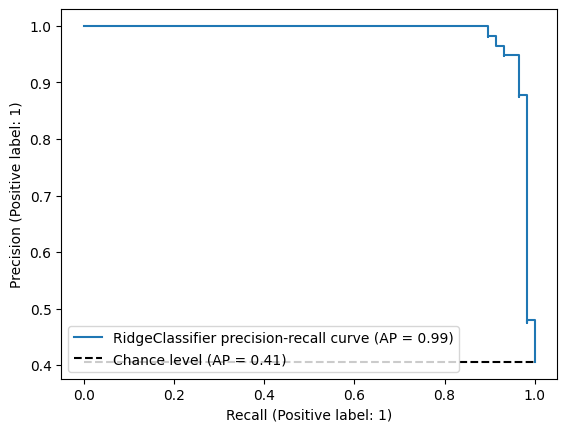

In [142]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Calculate precision-recall curve

def drawPRCurve(model, name):
    y_predict = model.fit(trainx, trainy).predict(testx)
    precision, recall, thresholds = precision_recall_curve(testy, y_predict)
    print(precision, recall, thresholds)
    display = PrecisionRecallDisplay.from_estimator(model, testx, testy, name=name, plot_chance_level=True)
    display.ax_.set_title(name + " precision-recall curve")




drawPRCurve(sgd, "RidgeClassifier")

drawPRCurve(dtree, "RidgeClassifier")
